In [1]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import container
import pickle as pkl
import numpy as np
from matplotlib.gridspec import GridSpec

font = {'family' : 'sans serif',
        'size'   : 18}

matplotlib.rc('font', **font)

In [2]:
config_suffix = 'all_patches'

Load Results from `evaluate.ipynb`

In [3]:
with open('cache/' + config_suffix + '_estimation_info.pkl', 'rb') as file:
    estimation_info = pkl.load(file) # estimates are uncalibrated here!
    file.close()

with open('cache/' + config_suffix + '_estimates_matrix.pkl', 'rb') as file1:
    estiamtes_matrix_ts = pkl.load(file1)
    file.close()

with open('cache/' + config_suffix + '_oracle_results.pkl', 'rb') as file2:
    oracle_results = pkl.load(file2)
    file2.close()

true_dsc = np.array([info_dict['true dice'] for info_dict in estimation_info])
uncali_est = np.array([info_dict['est dice'] for info_dict in estimation_info])

oracle_true = np.array([img_dict['true dsc curve'] for img_dict in oracle_results])
oracle_est = np.array([img_dict['est dsc curve'] for img_dict in oracle_results])
oracle_random = np.array([img_dict['random curve'] for img_dict in oracle_results])

In [4]:
# average model performance
true_dsc[:, 0].mean()

0.8867810145418127

Prepare

In [5]:
# jiggle x-values
box_width = 0.3
x_shift = np.random.uniform(-box_width/2, box_width/2, size=oracle_est.shape[0])

In [6]:
increase_true = oracle_true - oracle_true[:, 0].reshape(-1, 1)
increase_random = oracle_random - oracle_random[:, 0].reshape(-1, 1)

random_mean = increase_random.mean(axis=0)
random_std = increase_random.std(axis=0)

In [7]:
# select subsets for panel b and c
subset1 = oracle_true[:, 0] >= np.median(oracle_true[:, 0])
subset2 = ~ subset1

Plot

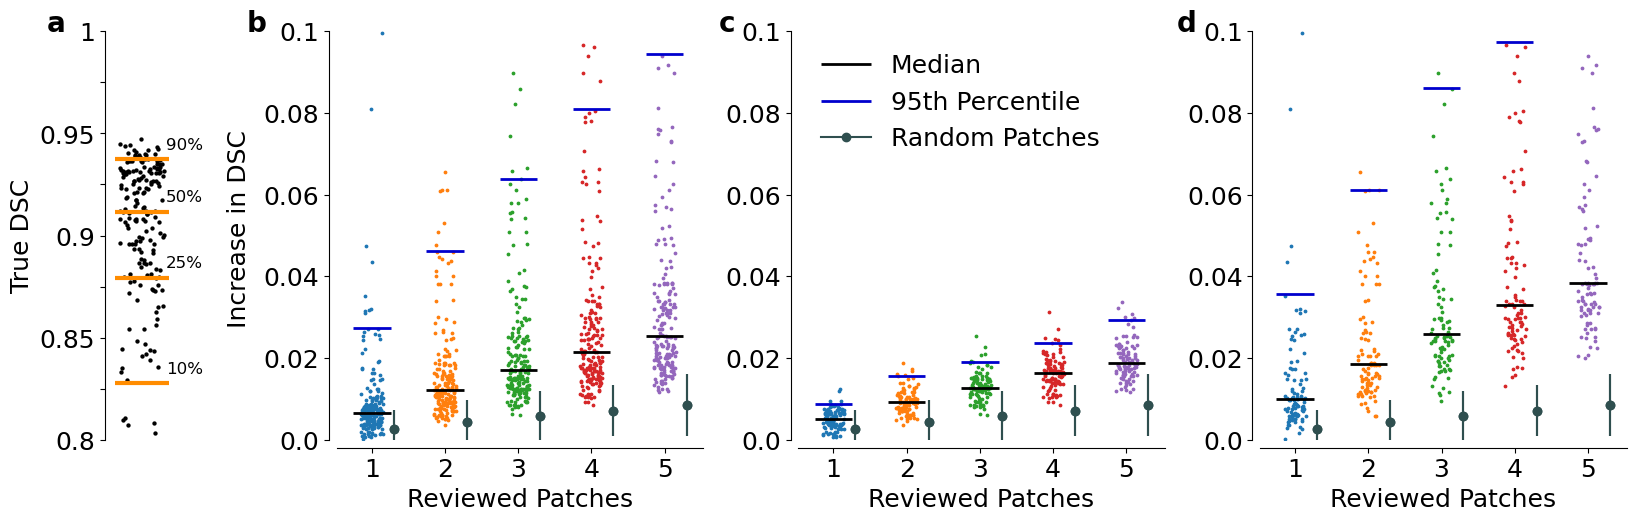

In [8]:
fig = plt.figure(figsize=(20, 5.3))
gs = GridSpec(1, 4, width_ratios=[0.45,1,1,1], wspace=0.3)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])
ax3 = fig.add_subplot(gs[3])
ax = [ax0, ax1, ax2, ax3]

for axi in ax: 
    axi.spines['top'].set_visible(False)
    axi.spines['right'].set_visible(False)
    axi.spines['left'].set_position(('axes', -0.02))
    axi.spines['bottom'].set_position(('axes', -0.02))
    axi.set_ylim(0, 0.1)
    #axi.set_ylim(, );
    tick_locs = axi.get_yticks()
    axi.set_yticks(tick_locs, [str(np.round(tick_loc, 2)) for tick_loc in tick_locs])
    axi.set_xticks(range(6), [str(i) for i in range(6)])


ax[0].scatter(0.17*x_shift, true_dsc[:, 0], s=4.5, c='black')
ax[0].set_xlim(-0.04, 0.08)
ax[0].set_ylim(0.8, 1)
quantile_values = [0.1, 0.25, 0.5, 0.9]
quantile = np.quantile(true_dsc[:, 0], quantile_values)
quantile_label = [str(i) for i in quantile_values]
for q in quantile:
    ax[0].hlines(y=q, xmin=-0.031, xmax=0.031, color='darkorange', linewidth=3)

# add labels to quantile hlines
for q, p in zip(quantile, quantile_values):
    ax[0].text(0.028, q+0.005, str(int(p*100)) + '%', fontsize=12)    

ax[0].set_aspect(2.35)
ax[0].set_ylabel('True DSC')
#ax[0].spines['bottom'].set_visible(False)
ax[0].get_xaxis().set_visible(False)
ax[0].spines['bottom'].set_visible(False)

ax[0].set_yticks([0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1],
                   ['0.8', '', '0.85', '', '0.9', '', '0.95', '', '1'])


for no_patch in range(1, 6):

    entire_test_set = increase_true[:, no_patch]
    subdata1 = increase_true[subset1, no_patch]
    subdata2 = increase_true[subset2, no_patch]

    def draw_plot(data, panel_idx):
        n = data.shape[0]
        ax[panel_idx].scatter(no_patch + x_shift[:n], data, s=3, alpha=1)
        ax[panel_idx].set_xlabel('Reviewed Patches')

        # add horizontal lines for median an 5th percentile
        percentiles = np.percentile(data, q=[50, 95])
        for perc_count, y_value in enumerate(percentiles):
            lcol = ['black', 'mediumblue']
            label = ['Median', '95th Percentile']

            if no_patch > 0:
                ax[panel_idx].errorbar(x=no_patch + 0.3, y=random_mean[no_patch], 
                            yerr=random_std[no_patch], marker='o', c='darkslategrey',
                            label='Random Patches')
                ax[panel_idx].hlines(y_value, xmin=no_patch - 1.7*box_width/2,
                            xmax=no_patch + 1.7*box_width/2, colors=lcol[perc_count],
                            lw=2, label=label[perc_count])
            if panel_idx == 2 and no_patch == 1:
                # get handles
                handles, labels = ax[panel_idx].get_legend_handles_labels()
                # remove the errorbars
                handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
                ax[panel_idx].legend(handles[:-1], labels[:-1], loc='upper left',
                                     frameon=False)
            # if panel_idx == 1:
                # ax[panel_idx].set_ylabel('Increase in DSC')

        return None
    
    draw_plot(entire_test_set, 1)
    draw_plot(subdata1, 2)
    draw_plot(subdata2, 3)


fig.text(0.20, 0.33, 'Increase in DSC', rotation=90, fontsize=18);
#fig.text(0.43, 0.01, 'Number of Reviewed Patches', fontsize=22);
panel_id_xloc = [0.11, 0.21, 0.446, 0.675]
for xloc, char in zip(panel_id_xloc, ['a', 'b', 'c', 'd']):
    fig.text(xloc, 0.88, char, {'weight': 'bold', 'size': 20})

fig.savefig('fig/doc_increase_absolute_' + config_suffix + '.png', dpi=150,
            bbox_inches='tight')